In [161]:
'''imports'''
from pulp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats
import pulp
import riskfolio as rp
%matplotlib inline

# Graphical


Note: Use Desmos, get the points and solve.

$$
\begin{split}
\text{max} \ \ \ \ & x_1 + 2x_2 \\
\text{s.t.} \ \ \ \ &  2x_1 - 2x_2 \le 3 \\
& -2x_1 +x_2 \le 2 \\
& 2x_1 + 2x_2 \le 13 \\
& x_1, \ x_2 \ge 0
\end{split}
$$

Change for $x_1$

$$
\begin{split}
\text{max} \ \ \ \ & x_1 + 2x_2 \\
\text{s.t.} \ \ \ \ &  x_1  \le \frac{3 + 2x_2}{2}\\
& x_1  \ge -\frac{2 - x_2}{2}\\
& x_1 \le \frac{13}2 - x_2 \\
& x_1, \ x_2 \ge 0
\end{split}
$$

Need for programming the solution now move onto code below

In [162]:
'''Constrains'''

x = np.linspace(0, 8, 801)

y1 = [(3+2*i)/2 for i in x]

y2 = [-(2-i)/2 for i in x]

y3 = [13/2 - i for i in x]


In [163]:
df = pd.DataFrame(index=x, columns=['Con1', 'Con2', 'Con3'])

In [164]:
df['Con1'] = y1
df['Con2'] = y2
df['Con3'] = y3

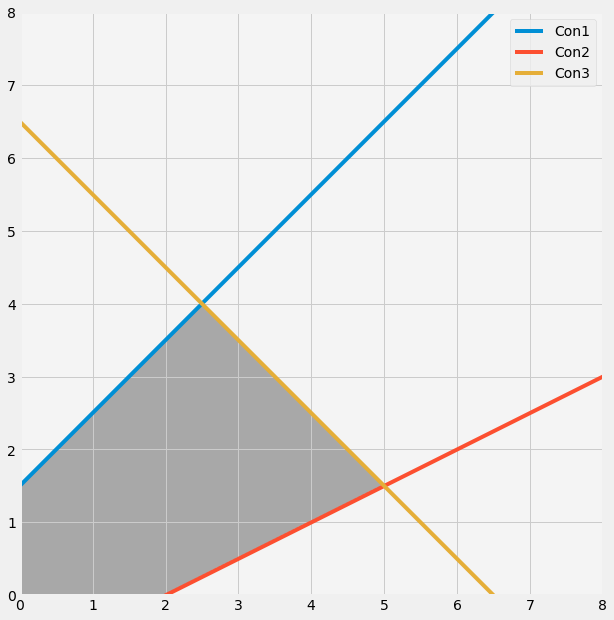

In [165]:
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(df.loc[:,'Con1'], label = 'Con1')
    plt.plot(df.loc[:,'Con2'], label = 'Con2')
    plt.plot(df.loc[:,'Con3'], label = 'Con3')
    d = np.linspace(0,8,300)
    x,y = np.meshgrid(d,d)
    plt.imshow( ((y>=0)&(y<=(3+2*x)/2) & (y>=(x-2)/2) & (y<=13/2 - x)).astype(int) , 
                extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Greys", alpha = 0.3)

    plt.legend()

## Getting points from desmos and then use the following. The points are from the example

### Just change mx to min if it is a min problem

In [166]:
x = [0, 0,   2.5, 5,   2]
y = [0, 1.5, 4,   1.5, 0]

obj = [y[i] + 2*x[i] for i in range(0,len(x))]

obj_df = pd.DataFrame(columns=['x', 'y', 'obj'])

obj_df['x'] = x
obj_df['y'] = y
obj_df['obj'] = obj

In [167]:
obj_df

,x,y,obj
0,0.0,0.0,0.0
1,0.0,1.5,1.5
2,2.5,4.0,9.0
3,5.0,1.5,11.5
4,2.0,0.0,4.0


# Parameter Estimation


In [168]:
'''Improrting the random sample of it'''
prices = pd.read_excel(r'C:\MFE\MFE Sem 2\ISE 447\Final\Data and Sharpe From Midterm.xlsx', sheet_name='Sheet1', index_col='Month')

## Monthly Returns
Note: I just made up some prices in an excel sheet.

In [169]:
prices

,AAA,BBB,CCC
Month,,,
0,1012,652,278
1,1024,704,145
2,953,742,163
3,973,694,218
4,980,633,198
5,1040,678,180
6,1006,726,205
7,1033,511,153
8,1007,706,267


In [170]:
returns = prices.pct_change().dropna(axis=0)
returns

,AAA,BBB,CCC
Month,,,
1,0.011858,0.079755,-0.478417
2,-0.069336,0.053977,0.124138
3,0.020986,-0.064690,0.337423
4,0.007194,-0.087896,-0.091743
5,0.061224,0.071090,-0.090909
6,-0.032692,0.070796,0.138889
7,0.026839,-0.296143,-0.253659
8,-0.025169,0.381605,0.745098
9,0.027805,-0.016997,-0.262172


## Dividend adjusted return

In [171]:
prices_AAA_div = prices

In [172]:
prices_AAA_div.loc[1:,'AAA'] = prices.loc[1:,'AAA']+200/12

In [173]:
prices_AAA_div

,AAA,BBB,CCC
Month,,,
0,1012.000000,652,278
1,1040.666667,704,145
2,969.666667,742,163
3,989.666667,694,218
4,996.666667,633,198
5,1056.666667,678,180
6,1022.666667,726,205
7,1049.666667,511,153
8,1023.666667,706,267


In [174]:
div_adj_ret = prices_AAA_div.pct_change().dropna(axis=0)

In [175]:
div_adj_ret

,AAA,BBB,CCC
Month,,,
1,0.028327,0.079755,-0.478417
2,-0.068225,0.053977,0.124138
3,0.020626,-0.064690,0.337423
4,0.007073,-0.087896,-0.091743
5,0.060201,0.071090,-0.090909
6,-0.032177,0.070796,0.138889
7,0.026402,-0.296143,-0.253659
8,-0.024770,0.381605,0.745098
9,0.027353,-0.016997,-0.262172


## Var Covar Matrix
Note: Just using AAA from Midterm II and changing the column titles

In [176]:
returns = pd.read_excel(r'C:\MFE\MFE Sem 2\ISE 447\Final\Data and Sharpe From Midterm.xlsx', sheet_name='Sheet2', index_col='Month')

In [177]:
cov_m = np.cov(returns.T,bias=True)

In [178]:
cov_m_df = pd.DataFrame(cov_m, index=returns.columns.tolist(), columns=returns.columns.tolist())

In [179]:
cov_m_df

,AAA,BBB,CCC
AAA,0.275297,-0.033064,-0.068121
BBB,-0.033064,0.604631,-0.228329
CCC,-0.068121,-0.228329,1.102535


## Downside Semi Var

In [180]:
returns['CCC'].values.tolist()

[0.31, 2.22, 0.78, -0.38, 1.43, 1.02, -0.79, 2.39, -0.98, 0.59, 0.27, 1.63]

In [181]:
'''Xbar'''

averages = [np.mean(returns[i]) for i in returns.columns.tolist()]

In [182]:
averages

[0.4916666666666667, 0.4383333333333333, 0.7074999999999999]

In [183]:
col_list = returns.columns.to_list()
dsv = [[(returns[col_list[i]].values.tolist()[t] - averages[i])**2 if returns[col_list[i]].values.tolist()[t] - averages[i] > 0 else 0 
        for t in range(0, len(returns)) ] 
         
        for i in range(0,len(averages))]

In [184]:
DSV_df = pd.DataFrame(index=range(0,1))
for i in range(0,len(averages)):
    DSV_df[col_list[i]] = np.mean(dsv[i])

In [185]:
DSV_df

,AAA,BBB,CCC
0,0.083691,0.162552,0.549532


## Value at Risk

In [186]:
beta = 1/12

In [187]:
VaR = returns
ret = [np.average(returns.loc[i,:]) for i in returns.index.to_list()]
VaR['Returns'] = ret
ret.sort(reverse=True)
VaR['Sorted'] = ret

VaR['CDF'] = [(1/12)*i for i in reversed(returns.index.tolist())]

In [188]:
for i in VaR.columns.to_list():
    VaR[i] = VaR[i].astype(float).map("{:.2%}".format)

In [189]:
VaR

,AAA,BBB,CCC,Returns,Sorted,CDF
Month,,,,,,
1,51.00%,58.00%,31.00%,46.67%,124.00%,100.00%
2,111.00%,39.00%,222.00%,124.00%,117.33%,91.67%
3,62.00%,77.00%,78.00%,72.33%,91.33%,83.33%
4,78.00%,119.00%,-38.00%,53.00%,72.33%,75.00%
5,-76.00%,107.00%,143.00%,58.00%,58.00%,66.67%
6,59.00%,113.00%,102.00%,91.33%,53.00%,58.33%
7,57.00%,42.00%,-79.00%,6.67%,46.67%,50.00%
8,22.00%,-144.00%,239.00%,39.00%,39.00%,41.67%
9,62.00%,71.00%,-98.00%,11.67%,20.33%,33.33%


Take the $\beta m + 1$ value so in our case:

In [190]:
VaR['Sorted'][11]

'11.67%'

That is the Value at Risk based on $\beta = 1/12$

# MAD Sensitivity Analysis


## $\mu_0$ decreases

### Midterm Riskfolio Sharpe and MAD

In [191]:
returns_df = pd.read_excel(r'C:\MFE\MFE Sem 2\ISE 447\Final\Data and Sharpe From Midterm.xlsx', sheet_name='Sheet2', index_col='Month')

In [192]:
'''Riskfolio Sharpe'''
Y = returns_df

# Building the portfolio object
port = rp.Portfolio(returns=Y)
# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

w.T

,AAA,BBB,CCC
weights,0.491293,0.277012,0.231694


In [193]:
means = Y.mean(axis=0)

In [194]:
means_df = pd.DataFrame(index=['means'], columns = returns_df.columns.to_list())
for i in means_df.columns.to_list():
    means_df[i] = means[i]

In [204]:

# Building the port2folio object
port2 = rp.Portfolio(returns=Y)
# Calculating optimal port2folio

'''This is where you must change the problem to manually input your own mean
cov, and min return. 
'''
port2.mu = means_df # Method to estimate expected returns based on historical data.
port2.cov = cov_m_df # Method to estimate covariance matrix based on historical data.
port2.lowerret = np.mean([np.mean(returns_df[i]) for i in returns_df.columns.to_list()])



# Estimate optimal port2folio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe

hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'
w = port2.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

w.T

,AAA,BBB,CCC
weights,0.454967,0.235801,0.309233


In [205]:
sum([means_df[i].values*w.T[i].values for i in returns_df.columns.to_list()])

array([0.54583333])

### Shadow Prices

If shadow price is positive, objective will decrease along with the change in the associated constraint.
0.00552 Decrease, we can say less risky as in-turn the sharpe ratio would also decrease.

If shadow price is negative, objective goes up when there is a decrease in constraint and down for the opposite
0.0012 Increase, More risky as the sharpe ratio would have inscreased

Makes sense as you are decreasing your avaliable cashflows, the optimal solution will have to go to use the riskier assets. As for $\mu_0$, if your setting the minimum return to be $\ge$ some value and then we increase that value, it would have to be the case that the objective would increase and vice versa if that objective would decrease. It would be pressing the solution closer and closer to riskier assets to meet that constraint.